# Unsupervised learning

When we do error-modulated learning with the `nengo.PES` rule,
we have a pretty clear idea of what we want to happen.
Years of neuroscientific experiments have yielded
learning rules explaining how synaptic strengths
change given certain stimulation protocols.
But what do these learning rules actually do
to the information transmitted across an
ensemble-to-ensemble connection?

We can investigate this in Nengo.
Currently, we've implemented the `nengo.BCM`
and `nengo.Oja` rules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo

In [2]:
print(nengo.BCM.__doc__)

Bienenstock-Cooper-Munroe learning rule.

    Modifies connection weights as a function of the presynaptic activity
    and the difference between the postsynaptic activity and the average
    postsynaptic activity.

    Notes
    -----
    The BCM rule is dependent on pre and post neural activities,
    not decoded values, and so is not affected by changes in the
    size of pre and post ensembles. However, if you are decoding from
    the post ensemble, the BCM rule will have an increased effect on
    larger post ensembles because more connection weights are changing.
    In these cases, it may be advantageous to scale the learning rate
    on the BCM rule by ``1 / post.n_neurons``.

    Parameters
    ----------
    learning_rate : float, optional
        A scalar indicating the rate at which weights will be adjusted.
    pre_synapse : `.Synapse`, optional
        Synapse model used to filter the pre-synaptic activities.
    post_synapse : `.Synapse`, optional
        Synapse model

In [3]:
print(nengo.Oja.__doc__)

Oja learning rule.

    Modifies connection weights according to the Hebbian Oja rule, which
    augments typically Hebbian coactivity with a "forgetting" term that is
    proportional to the weight of the connection and the square of the
    postsynaptic activity.

    Notes
    -----
    The Oja rule is dependent on pre and post neural activities,
    not decoded values, and so is not affected by changes in the
    size of pre and post ensembles. However, if you are decoding from
    the post ensemble, the Oja rule will have an increased effect on
    larger post ensembles because more connection weights are changing.
    In these cases, it may be advantageous to scale the learning rate
    on the Oja rule by ``1 / post.n_neurons``.

    Parameters
    ----------
    learning_rate : float, optional
        A scalar indicating the rate at which weights will be adjusted.
    pre_synapse : `.Synapse`, optional
        Synapse model used to filter the pre-synaptic activities.
    post_sy

## Step 1: Create a simple communication channel

The only difference between this network and most
models you've seen so far is that we're going to
set the decoder solver in the communication channel
to generate a full connection weight matrix
which we can then learn using typical delta learning rules.

In [4]:
model = nengo.Network()
with model:
    sin = nengo.Node(lambda t: np.sin(t * 4))

    pre = nengo.Ensemble(100, dimensions=1)
    post = nengo.Ensemble(100, dimensions=1)

    nengo.Connection(sin, pre)
    conn = nengo.Connection(
        pre, post, solver=nengo.solvers.LstsqL2(weights=True))

    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

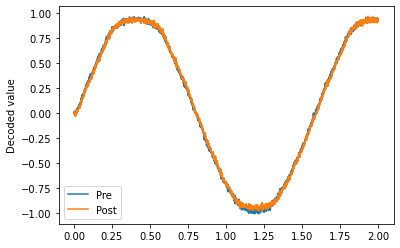

In [5]:
# Verify that it does a communication channel
with nengo.Simulator(model) as sim:
    sim.run(2.0)

plt.figure()
plt.plot(sim.trange(), sim.data[pre_p], label="Pre")
plt.plot(sim.trange(), sim.data[post_p], label="Post")
plt.ylabel("Decoded value")
plt.legend(loc="best");

## What does BCM do?

In [6]:
conn.learning_rule_type = nengo.BCM(learning_rate=5e-10)
with model:
    weights_p = nengo.Probe(conn, 'weights', synapse=0.01, sample_every=0.01)

In [7]:
with nengo.Simulator(model) as sim:
    sim.run(20.0)

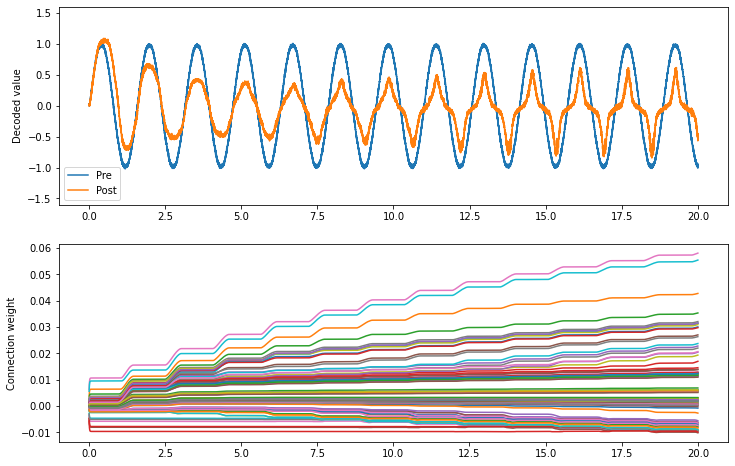

In [8]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[pre_p], label="Pre")
plt.plot(sim.trange(), sim.data[post_p], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")
plt.subplot(2, 1, 2)
# Find weight row with max variance
neuron = np.argmax(np.mean(np.var(sim.data[weights_p], axis=0), axis=1))
plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][..., neuron])
plt.ylabel("Connection weight");

The BCM rule appears to cause the ensemble
to either be on or off.
This seems consistent with the idea that it potentiates
active synapses, and depresses non-active synapses.

As well, we can show that BCM sparsifies the weights.
The sparsity measure below uses the Gini measure of sparsity,
for reasons explained [in this paper](https://arxiv.org/pdf/0811.4706.pdf).

In [9]:
def sparsity_measure(vector):  # Gini index
    # Max sparsity = 1 (single 1 in the vector)
    v = np.sort(np.abs(vector))
    n = v.shape[0]
    k = np.arange(n) + 1
    l1norm = np.sum(v)
    summation = np.sum((v / l1norm) * ((n - k + 0.5) / n))
    return 1 - 2 * summation


print(
    "Starting sparsity: {0}".format(sparsity_measure(sim.data[weights_p][0])))
print("Ending sparsity: {0}".format(sparsity_measure(sim.data[weights_p][-1])))

Starting sparsity: 0.19227698463624876
Ending sparsity: 0.44747792943447917


## What does Oja do?

In [10]:
conn.learning_rule_type = nengo.Oja(learning_rate=6e-8)

In [11]:
with nengo.Simulator(model) as sim:
    sim.run(20.0)

Starting sparsity: 0.1847274201845709
Ending sparsity: 0.27035712172887494


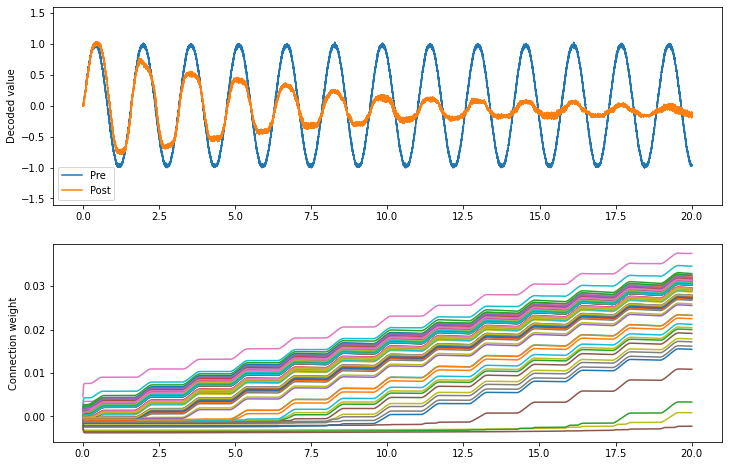

In [12]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[pre_p], label="Pre")
plt.plot(sim.trange(), sim.data[post_p], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")
plt.subplot(2, 1, 2)
# Find weight row with max variance
neuron = np.argmax(np.mean(np.var(sim.data[weights_p], axis=0), axis=1))
plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][..., neuron])
plt.ylabel("Connection weight")
print(
    "Starting sparsity: {0}".format(sparsity_measure(sim.data[weights_p][0])))
print("Ending sparsity: {0}".format(sparsity_measure(sim.data[weights_p][-1])))

The Oja rule seems to attenuate the signal across the connection.

## What do BCM and Oja together do?

We can apply both learning rules to the same connection
by passing a list to `learning_rule_type`.

In [13]:
conn.learning_rule_type = [
    nengo.BCM(learning_rate=5e-10), nengo.Oja(learning_rate=2e-9)
]

In [14]:
with nengo.Simulator(model) as sim:
    sim.run(20.0)

Starting sparsity: 0.1668150991288152
Ending sparsity: 0.4208079503421528


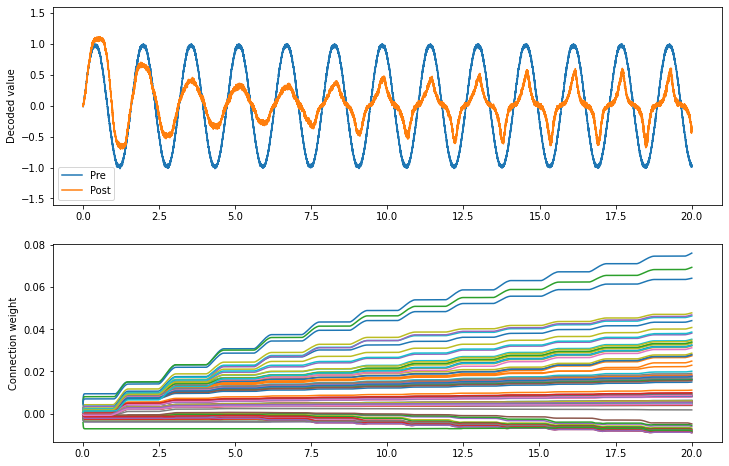

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[pre_p], label="Pre")
plt.plot(sim.trange(), sim.data[post_p], label="Post")
plt.ylabel("Decoded value")
plt.ylim(-1.6, 1.6)
plt.legend(loc="lower left")
plt.subplot(2, 1, 2)
# Find weight row with max variance
neuron = np.argmax(np.mean(np.var(sim.data[weights_p], axis=0), axis=1))
plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][..., neuron])
plt.ylabel("Connection weight")
print(
    "Starting sparsity: {0}".format(sparsity_measure(sim.data[weights_p][0])))
print("Ending sparsity: {0}".format(sparsity_measure(sim.data[weights_p][-1])))

The combination of the two appears to accentuate
the on-off nature of the BCM rule.
As the Oja rule enforces a soft upper or lower bound
for the connection weight, the combination
of both rules may be more stable than BCM alone.

That's mostly conjecture, however;
a thorough investigation of the BCM and Oja rules
and how they interact has not yet been done.